In [1078]:
import  numpy as np
import matplotlib.pyplot as plt
from math import *
from tools import *
from tp3_etu import *
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


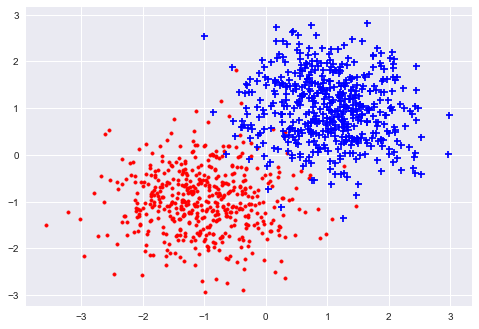

In [1079]:
### Donnees artificielles
plt.ion()
xgentrain,ygentrain = gen_arti(data_type=0,sigma=0.5,nbex=1000,epsilon=0.1)
xgentest,ygentest = gen_arti(data_type=0,sigma=0.5,nbex=1000,epsilon=0.1)
plt.figure()
plot_data(xgentrain,ygentrain)

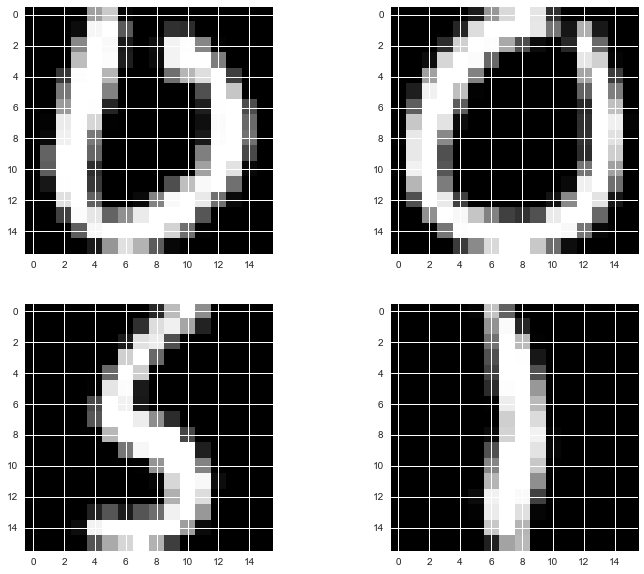

In [1080]:
### Donnees reelles
plt.figure()
xuspstrain,yuspstrain = load_usps("USPS_train.txt")
xuspstest,yuspstest = load_usps("USPS_test.txt")
x06train,y06train = get_usps([0,6],xuspstrain,yuspstrain)
x06test,y06test = get_usps([0,6],xuspstest,yuspstest)

x15train,y15train = get_usps([1,5],xuspstrain,yuspstrain)
x15test,y15test = get_usps([1,5],xuspstest,yuspstest)

plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
show_usps(x06train[11])

plt.subplot(2, 2, 2)
show_usps(x06train[10])

plt.subplot(2, 2, 3)
show_usps(x15train[0])

plt.subplot(2, 2, 4)
show_usps(x15train[1])


* Instinctivement le problème de différencier un chiffre contre tous les autres sera plus facile que celui de différencier deux chiffres.
Certaines paires de chiffres seront plus difficile à différencier que d'autres, comme les paires $(3, 8)$; $(0, 8)$, $(8, 9)$, ... D'un autre coté il sera probablement facile de différencier le chiffre 1 des autres chiffres, de part sa forme très linéaire.

## Classifieur bayésien naïf

In [1081]:
class Classifier:

    def __init__(self):        
        pass
    
    def predict(self, data):
        predictions = []
        res = []
        for l in self.labels_set:            
            tmp = 1/(((2*pi)**0.5)*self.sigma[l]) * np.exp(-np.power(data-self.mu[l],2)/np.power(2*self.sigma[l],2))
            res.append(np.log(tmp+10**(-10)).sum(1))
        data_res = np.array(res).T
        
        return np.array([self.labels_list[np.argmax(data_res[i])] for i in range (len(data))])
         
    def fit(self,data,labels):
        labels_set = set(labels)
        labels_list = list(labels_set)
        self.mu = dict()  #mu[i, j] =  E(xj|y=i)
        self.sigma = dict()  #sigma[i, j] =  Var(xj|y=i)
        self.p_y = dict()
        
        for i in list(labels_set):
            self.mu[i] = data[labels == i, :].mean(0) + 10**(-10)
            self.sigma[i] = data[labels == i, :].std(0, ddof = 1) + 10**(-10)
            self.p_y[i] = (labels == i).mean
            
        self.labels_set = labels_set
        self.labels_list = labels_list
                
    def score(self,data,labels):
        return (self.predict(data)==labels).mean()

<h2>Tests sur les valeurs artificielles</h2>

<h4>Data type 0<h/4>

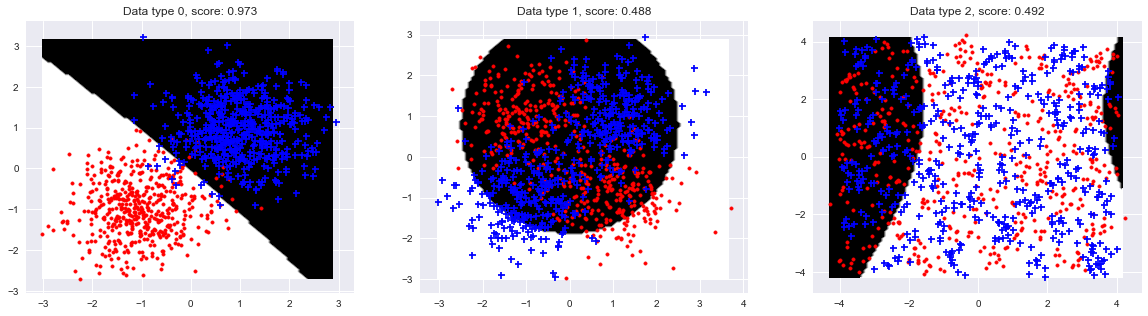

In [1084]:
xgentrain0, ygentrain0 = gen_arti(data_type=0,sigma=0.5,nbex=1000,epsilon=0.1)
xgentest0, ygentest0 = gen_arti(data_type=0,sigma=0.5,nbex=1000,epsilon=0.1)

xgentrain1, ygentrain1 = gen_arti(data_type=1,sigma=0.5,nbex=1000,epsilon=0.1)
xgentest1, ygentest1 = gen_arti(data_type=1,sigma=0.5,nbex=1000,epsilon=0.1)

xgentrain2, ygentrain2 = gen_arti(data_type=2,sigma=0.5,nbex=1000,epsilon=0.1)
xgentest2, ygentest2 = gen_arti(data_type=2,sigma=0.5,nbex=1000,epsilon=0.1)


plt.figure(figsize=(20, 5))

F = Classifier()
F.fit(xgentrain0,ygentrain0)
score0 = F.score(xgentest0, ygentest0)

plt.subplot(1, 3, 1)
plot_frontiere(xgentest0, F.predict, step = 100)
plot_data(xgentest0,ygentest0)
plt.title('Data type 0, score: {}'.format(score0))

F = Classifier()
F.fit(xgentrain1,ygentrain1)
score1 = F.score(xgentest1, ygentest1)

plt.subplot(1, 3, 2)
plot_frontiere(xgentest1, F.predict, step = 100)
plot_data(xgentest1,ygentest1)
plt.title('Data type 1, score: {}'.format(score1))


F = Classifier()
F.fit(xgentrain2,ygentrain2)
score2 = F.score(xgentest2, ygentest2)

plt.subplot(1, 3, 3)
plot_frontiere(xgentest2, F.predict, step = 100)
plot_data(xgentest2,ygentest2)
plt.title('Data type 2, score: {}'.format(score2))



Le classifier n'est pas capable de séparer les données en mélange de 4 gaussiennes et en échéquier.

## Test sur les données réels

In [1085]:
def fit_xy(F, n1, n2):
    '''Fait fitter le Classifier F aux données n1, n2 de USPS'''
    xtrain,ytrain = get_usps([n1,n2],xuspstrain,yuspstrain)
    xtest,ytest = get_usps([n1,n2],xuspstest,yuspstest)
    
    F.fit(xtrain, ytrain)
    return F.score(xtest, ytest)

Scores de la predictions pour toutes les paires de chiffres


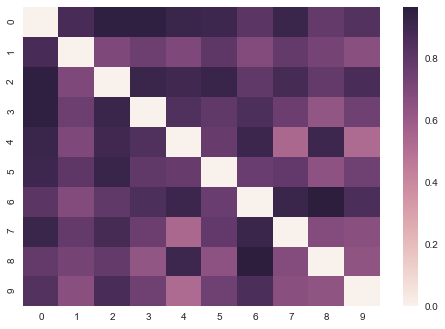

In [1088]:
F = Classifier()

print('Scores de la predictions pour toutes les paires de chiffres')
matrix = np.zeros((10,10))
for i in range(9):
    for j in range(i+1, 10):
        p = fit_xy(F, i, j)
        matrix[i, j] = max(p, 1-p)
        matrix[j, i] = matrix[i, j]
        
sns.heatmap(matrix)

On trouve des scores globalement très satisfaisants (souvent au-dessus de $90\%$ de réussite), mais ce score baisse fortement pour certaines paires plus difficiles à différencier, comme les paires $(3, 8)$, $(5, 8)$, $(4, 7)$.

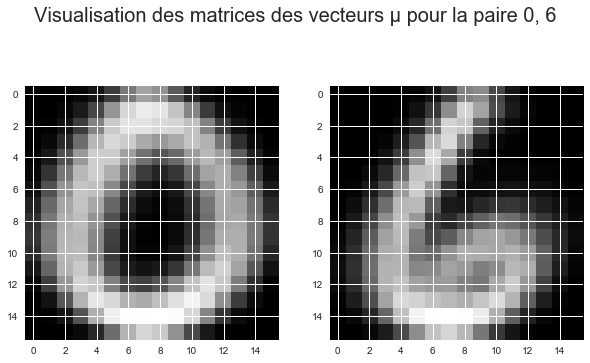

In [1089]:
F = Classifier()
i, j = 0, 6
fit_xy(F, i, j)

plt.figure(figsize=(10, 6))
plt.suptitle("Visualisation des matrices des vecteurs μ pour la paire 0, 6", fontsize = 20)

plt.subplot(1, 2, 1)
show_usps(np.array(F.mu[i]))

plt.subplot(1, 2, 2)
show_usps(np.array(F.mu[j]))


## Observations
<p>La couleur de pixel correspond à la probabilité que ce pixel ne soit pas noir si l'image observée est un correspond au label.</p>
Ainsi, dans la matrice d'une classe donnée, un cellule avec une valeur élevée indique que cette cellule a un forte probabilité de contenir des pixels blancs dans les images de la classe. A l'inverse, une cellule noire indique une qu'il est peu probable que la zone soit parcourue par le chiffre de la classe. 

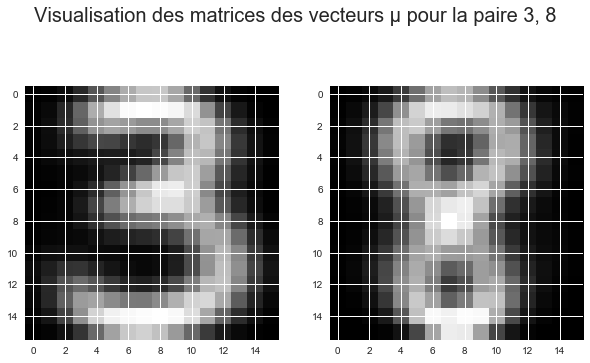

In [1090]:
F = Classifier()
i, j = 3, 8
fit_xy(F, i, j)

plt.figure(figsize=(10, 6))
plt.suptitle("Visualisation des matrices des vecteurs μ pour la paire 3, 8", fontsize = 20)

plt.subplot(1, 2, 1)
show_usps(np.array(F.mu[i]))

plt.subplot(1, 2, 2)
show_usps(np.array(F.mu[j]))

Pour cette paire on voit presque graphiquement d'où vient le score de 60% seulement de réussite: les parties verticales droites des deux matrices mu sont très fortement corrélés, seuls une petite partie de l'image (les pixels à droite verticalement du centre, et au milieu horizontalement) permet de faire la différence entre les deux classes.

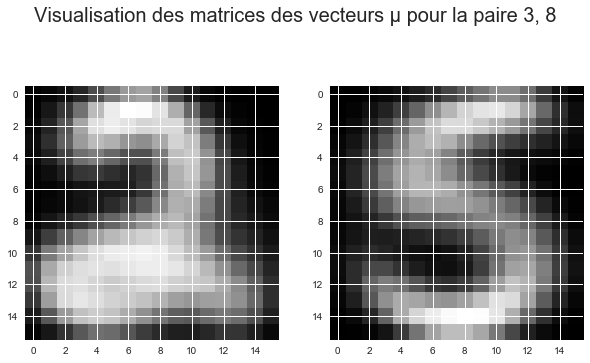

In [1091]:
F = Classifier()
i, j = 2, 5
fit_xy(F, i, j)

plt.figure(figsize=(10, 6))
plt.suptitle("Visualisation des matrices des vecteurs μ pour la paire 3, 8", fontsize = 20)

plt.subplot(1, 2, 1)
show_usps(np.array(F.mu[i]))

plt.subplot(1, 2, 2)
show_usps(np.array(F.mu[j]))


# Question 2.1

In [1092]:
def optimize(f, df, xinit, eps, max_iter):
    x = xinit
    histo_x, histo_f, histo_df = [x], [f(x)], [df(x)]
    for i in range(1,max_iter):
        x = x - eps*df(x)
        histo_x.append(x)
        histo_f.append(f(x))
        histo_df.append(df(x))
    
    return np.array(histo_x), np.array(histo_f), np.array(histo_df)

# Question 2.2

In [1093]:
def f(x):
    return x*cos(x)

def df(x):
    return cos(x) - x*sin(x)

In [1094]:
def f2(x):
    return 100*(x[1] - x[0]**2)**2 + (1 - x[0])**2

def df2(x):
    return np.array([200*(x[1] - x[0]**2)*(-2*x[0]) - 2*(1-x[0]), 200*(x[1] - x[0]**2)])



/Users/Antonin/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log


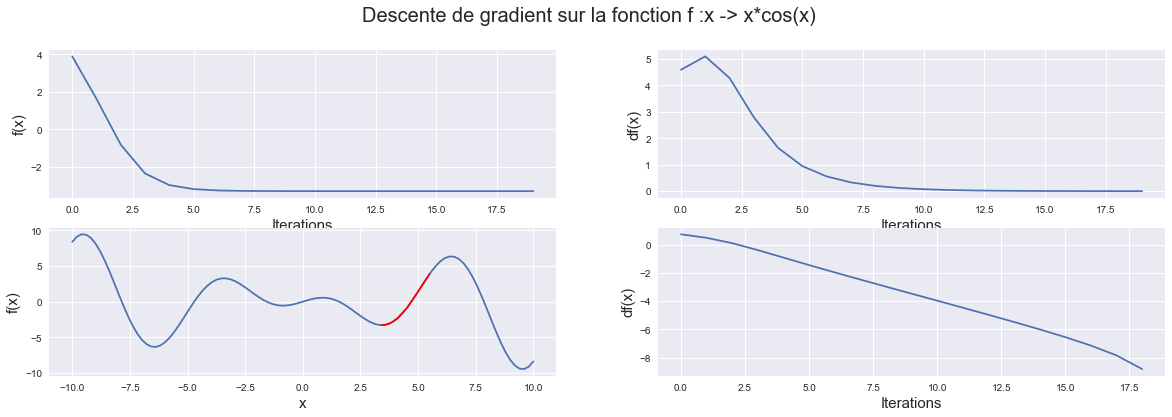

In [1095]:
max_iter = 20
hx, hf, hdf = optimize(f, df, 5.5, 0.1, max_iter)

plt.figure(figsize = (20, 6))
plt.suptitle("Descente de gradient sur la fonction f :x -> x*cos(x)", fontsize = 20)

plt.subplot(2, 2, 1)
plt.plot(np.arange(0, max_iter), hf)
plt.xlabel('Iterations', fontsize = 15)
plt.ylabel('f(x)', fontsize = 15)

plt.subplot(2, 2, 2)
plt.plot(np.arange(0, max_iter), hdf)
plt.xlabel('Iterations', fontsize = 15)
plt.ylabel('df(x)', fontsize = 15)

plt.subplot(2, 2, 3)
t=np.linspace(-10, 10, 100)
plt.plot(t, [f(x) for x in t])
plt.plot(hx, hf, color = 'red')

plt.xlabel('x', fontsize = 15)
plt.ylabel('f(x)', fontsize = 15)

plt.subplot(2, 2, 4)
t2=np.arange(0, max_iter)

plt.plot(t2, np.log(hx-hx[-1]))
plt.xlabel('Iterations', fontsize = 15)
plt.ylabel('df(x)', fontsize = 15)

plt.show()

/Users/Antonin/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in log


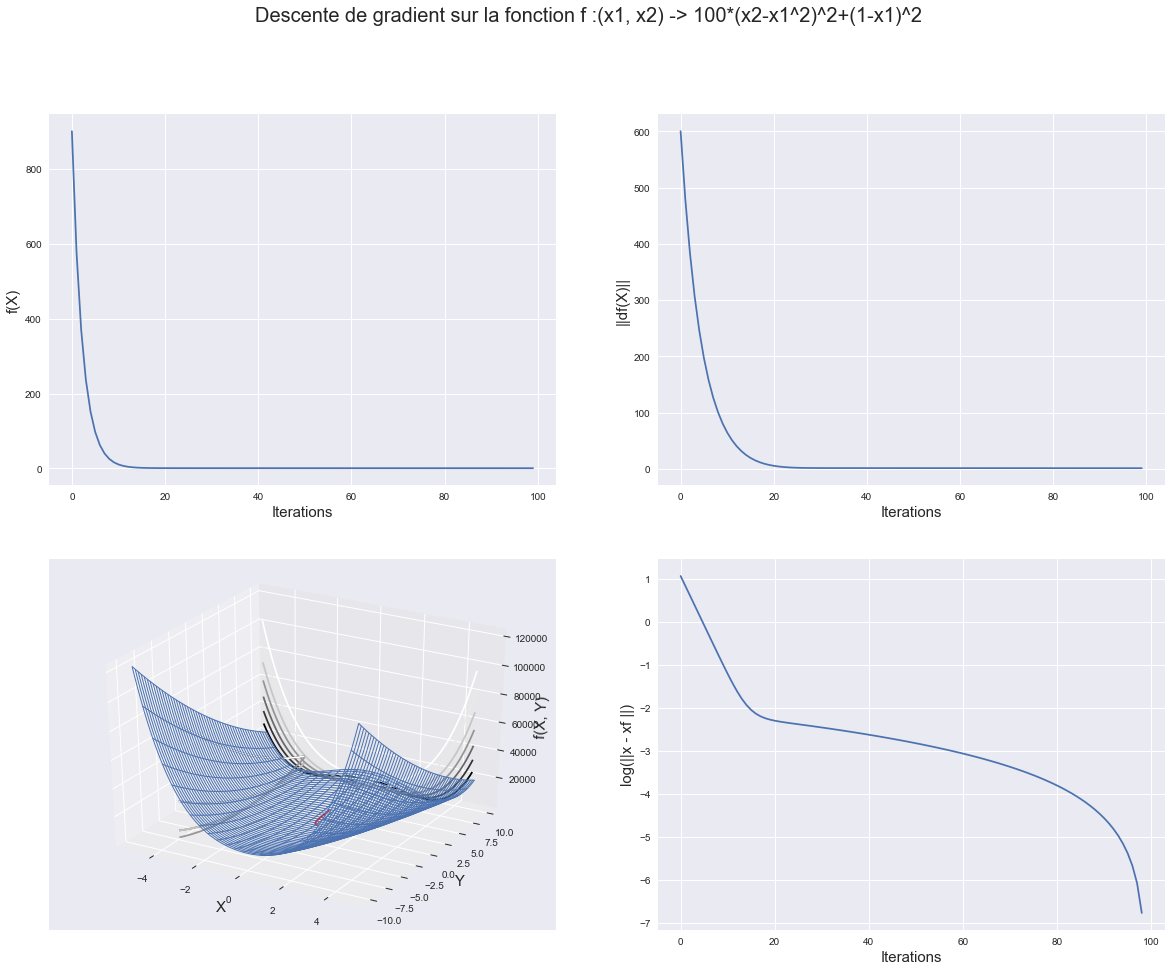

In [1096]:
max_iter = 100
hx, hf, hdf = optimize(f2, df2, np.array([0, 3]), 0.001, max_iter)

fig = plt.figure(figsize = (20, 15))
fig.suptitle("Descente de gradient sur la fonction f :(x1, x2) -> 100*(x2-x1^2)^2+(1-x1)^2", fontsize = 20)

t2=np.arange(0, max_iter)

plt.subplot(2, 2, 1)
plt.plot(t2, hf)
plt.xlabel('Iterations', fontsize = 15)
plt.ylabel('f(X)', fontsize = 15)

plt.subplot(2, 2, 2)
plt.plot(t2, np.linalg.norm(hdf, axis = 1))
plt.xlabel('Iterations', fontsize = 15)
plt.ylabel('||df(X)||', fontsize = 15)


ax = fig.add_subplot(2, 2, 3, projection='3d')

x = np.arange(-5.0, 5.0, 0.1)
y = np.arange(-10.0, 10.0, 0.1)
X,Y = np.meshgrid(x, y) # grid of point
f2_grid = f2((X, Y)) # evaluation of the function on the grid
ax.plot_wireframe(X, Y, f2_grid, rstride=4, cstride=4, linewidth=1)
cset = ax.contour(X, Y, f2_grid, zdir='x', offset=-pi)
cset = ax.contour(X, Y, f2_grid, zdir='y', offset=3*pi)


hxx, hxy = hx[:, 0], hx[:, 1]
ax.plot(hxx, hxy, hf, color = 'red')

ax.set_xlabel('X', fontsize = 15)
ax.set_ylabel('Y', fontsize = 15)
ax.set_zlabel('f(X, Y)', fontsize = 15)

plt.subplot(2, 2, 4)
plt.plot(t2, np.log(np.linalg.norm(hx-hx[-1], axis = 1)))
plt.xlabel('Iterations', fontsize = 15)
plt.ylabel('log(||x - xf ||)', fontsize = 15)

plt.show()

## Observations 
Pour cette dernière fonction l'optimisation est très sensible aux paramètres de la descente de gradient: si le pas n'est pas suffisament petit ou si $x_1$ et $x_2$ sont trop élevés à l'initialisation, la descente de gradient diverge.

<h4>Visualisation plus en détail de la fonction précédente</h4>

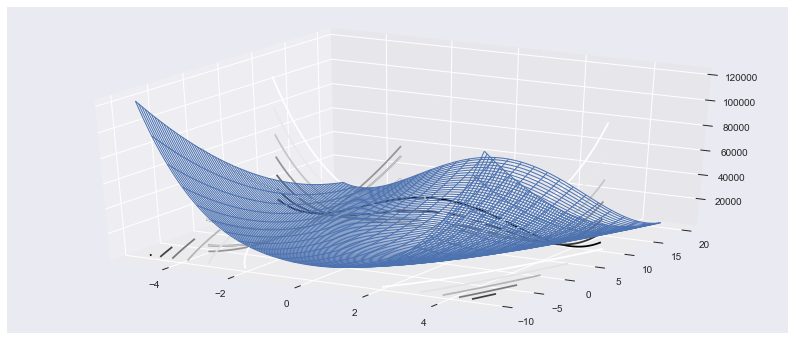

In [1097]:
x = np.arange(-5.0, 5.0, 0.1)
y = np.arange(-10.0, 20.0, 0.1)
X,Y = np.meshgrid(x, y) # grid of point
f2_grid = f2((X, Y)) # evaluation of the function on the grid

fig = plt.figure(figsize=(14,6))

# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(1, 1, 1, projection='3d')


ax.plot_wireframe(X, Y, f2_grid, rstride=4, cstride=4, linewidth=1)
cset = ax.contour(X, Y, f2_grid, zdir='z', offset=-pi)
cset = ax.contour(X, Y, f2_grid, zdir='x', offset=-pi)
cset = ax.contour(X, Y, f2_grid, zdir='y', offset=3*pi)


# Partie 3

<h3>Classification plug-in</h3>
<p> Avec $X = (x^0 \cdots x^N)$ (où $x^0 = (1 \cdots 1)$), $Y = (y^i)_{1\leq i \leq N}$ et $W = (w_i)_{0 \leq i \leq d}$, on peut écrire la fonction de coût sous forme matricielle:
$$ L(W, X)= \|XW - Y \|_2^2 $$

On peut alors calculer facilement son gradient: 
$$ \nabla L(W, X) = 2*X^T*(XW - Y) $$ 

<h3>Régression logistique</h3>
<p> Avec les notations précédente, la fonction de coût s'écrit:
$$ L(W, X)= \sum_{i=1}^N { log (1 + exp ( - Y * XW))} $$
où $(.*.)$ correspond au produit terme à terme.

<p> On a: 
$$ \forall 0 \leq k \leq d, 
\begin{align}
\frac{\partial L}{\partial w_k}(w,X) &= \sum_{i=1}^N { \frac{1}{1+exp \left( -y^i \sum_{j=0}^d {w_j x^i_j} \right )} * \left(-y^i*x^i_k*exp \left( -y^i \sum_{j=0}^d {w_j x^i_j} \right) \right)} \\
&= \sum_{i=1}^N {-y^i*x^i_k* \frac{1}{1+exp \left( y^i*f_w(x^i) \right) } }
\end{align}
$$ 
D'où:
$$ \begin{align}
\nabla L(w, X) &= 
\sum_{i=1}^N {
\left( 
\begin{array}{c}
1 \\
x^i_1 \\
\vdots \\
x^i_d
\end{array}
\right) * \left( - \frac{ y^i} { 1+exp \left( y^i*f_w(x^i) \right) } \right) } \\
& =
\sum_{i=1}^N {
\left(
\begin{array}{c}
1 \\
x^i_1 \\
\vdots \\
x^i_d
\end{array}
\right) * \left( - y^i * \sigma \left( -y^i*f_w(x^i) \right)   \right) } \\
&= X^T \left(-Y*\sigma(- Y * XW) \right)
\end{align}$$

In [1098]:
def mse(w,data,label):
    '''On suppose la ligne de 1 ajoutée au dataset au préalable'''
    #data = data.reshape(len(label), -1)
    label = label.reshape(-1, 1)
    
    return np.power((np.dot(data, w.T) - label), 2).mean()

def grad_mse(w,data,label):
    #data = data.reshape(len(label), -1)
    label = label.reshape(-1)
    grad = 2*np.dot(data.T,(np.dot(data, w.T) - label))
    
    return grad


In [1099]:
def reglog(w, data, label):
    '''On suppose la ligne de 1 ajoutée au dataset au préalable'''
    ae = - label * data.dot(w)
    S = np.log(1 + np.exp(ae))
    return np.sum(S)
 
    
def sigma(tab):
    '''Applique la fonction sigma: x -> 1/(1/exp(-x)) à tous les éléments du tableau en utilisant la bibliothèque numpy'''
    return 1/(1+ np.exp(-tab))   
    
    
def grad_reglog(w, data, label): 
    sig = sigma( - label * data.dot(w)) 
    ysig = - label * sig
    return np.dot(data.T, ysig)
    

<h3>Coûts en fonction des poids</h3>

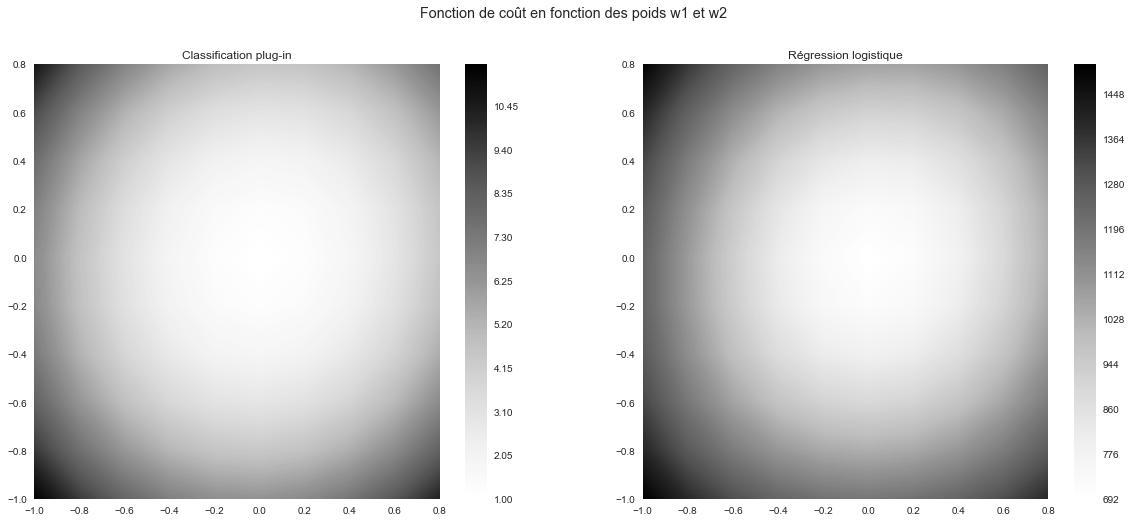

In [1100]:
xgentrain,ygentrain = gen_arti(data_type=2,sigma=1,nbex=1000,epsilon=0.1)
xgentest,ygentest = gen_arti(data_type=2,sigma=1,nbex=1000,epsilon=0.1)

data = np.hstack((np.ones((xgentrain.shape[0], 1)), xgentrain))
label = np.where(ygentrain == 0, 1, -1)


g_mse = lambda w: mse(np.array([0, w[0], w[1]]), data, label)
g_reglog = lambda w: reglog(np.array([0, w[0], w[1]]), data, label)

grid, xx, yy = make_grid(xmin=-1, xmax=1, ymin=-1, ymax=1, step=10)

plt.figure(figsize=(20, 8))
plt.suptitle("Fonction de coût en fonction des poids w1 et w2")

plt.subplot(1, 2, 1)
plt.title("Classification plug-in")
plt.contourf(xx,yy, np.array(list(map(g_mse, grid))).reshape(xx.shape), 256)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Régression logistique")
plt.contourf(xx,yy, np.array(list(map(g_reglog, grid))).reshape(xx.shape), 256)
plt.colorbar()

plt.show()

## Descente de gradient pour déterminer les poids optimaux

In [1101]:
xgentrain,ygentrain = gen_arti(data_type=0, sigma=0.5,nbex=1000,epsilon=0.1)
xgentest,ygentest = gen_arti(data_type=0, sigma=0.5,nbex=1000,epsilon=0.1)

data = np.hstack((np.ones((xgentrain.shape[0], 1)), xgentrain))
label = np.where(ygentrain == 0, 1, -1)

winit = np.array([0, 2, 2])

<h3><font color="grey">Classification plug-in</h3>

In [1102]:
g_mse = lambda w: mse(np.array([0, w[1], w[2]]), data, label)
dg_mse = lambda w: grad_mse(np.array([0, w[1], w[2]]), data, label)

eps_mse = 0.0001
max_iter_mse = 100

w_mse, L_mse, dL_mse = optimize(g_mse, dg_mse, winit, eps_mse, max_iter_mse)

<h3><font color="grey">Regression logistique</h3>

In [1103]:
g_rl = lambda w: reglog(np.array([w[0], w[1], w[2]]), data, label)
dg_rl = lambda w: grad_reglog(np.array([w[0], w[1], w[2]]), data, label)

eps_rl = 0.01
max_iter_rl = 10000

w_rl, L_rl, dL_rl = optimize(g_rl, dg_rl, winit, eps_rl, max_iter_rl)

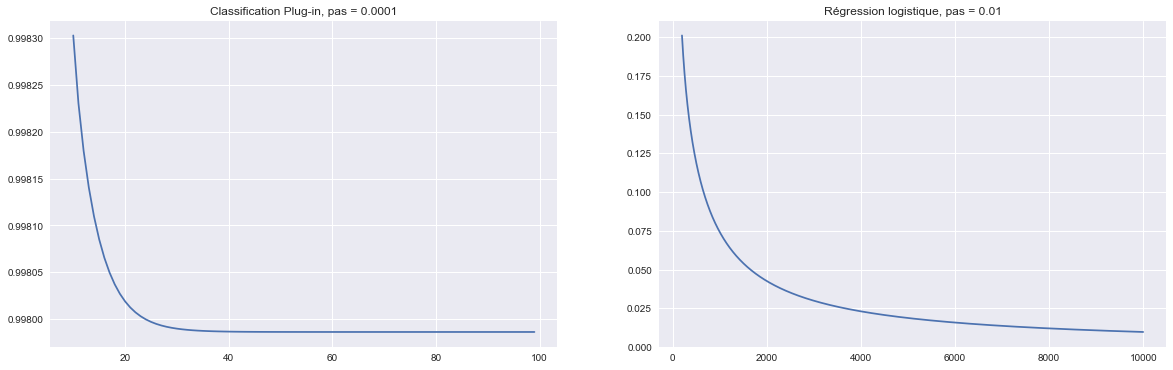

In [1104]:
plt.figure(figsize= (20, 6))

plt.subplot(1, 2, 1)
plt.title('Classification Plug-in, pas = {}'.format(eps_mse))
plt.plot(np.arange(10, max_iter_mse), L_mse[10:])

plt.subplot(1, 2, 2)
plt.title('Régression logistique, pas = {}'.format(eps_rl))
plt.plot(np.arange(200, max_iter_rl), L_rl[200:])

plt.show()

<p>Pour pas que l'échelle l'axe des ordonnées ne soit trop grande, on ne représente pas le coût pour les premières itérations.</p>
<p>Il apparait que la descente de gradient pour la classification plug-in nécessite un pas très faible (de l'ordre de $10^{-4}$), tandis que pour la régression logistique le pas peut être nettement plus élevé (de l'ordre de $10^{-2}$).
Par ailleurs, la classification plug-in semble plus vulnérable aux minimums locaux que la régression logistique. </p>

## Frontières de décision

<h3><font color="grey">Classification plug-in</h3>

In [1109]:
w_mse_star = [w_mse[-1][0], -w_mse[-1][1], w_mse[-1][2]]
#Pour une raison inconnue, un des poids est inversé

def mse_w(data):
    #X = np.hstack((np.ones((data.shape[0], 1)), data))
    X = data
    f = X.dot(w_mse_star[1:])
    res = np.where(f > 0, 1, -1)
    return res

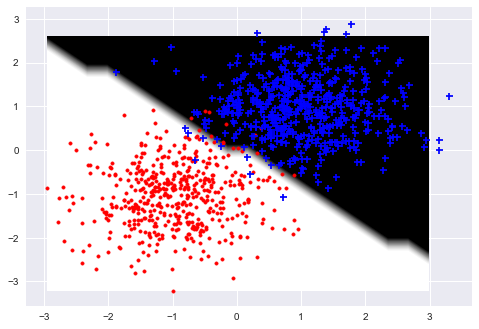

In [1110]:
plot_frontiere(xgentrain, mse_w, step = 20)
plot_data(xgentrain,ygentrain)

<h3><font color="grey">Regression logistique</h3>

In [1111]:
w_star_rl = [w_rl[-1][0], -w_rl[-1][1], w_rl[-1][2]]
#Pour une raison inconnue, un des poids est inversé

def reglog_w(data):
    X = data
    sf = sigma(X.dot(w_star_rl[1:]))
    res = np.where(sf > 0.5, 1, -1)
    return res

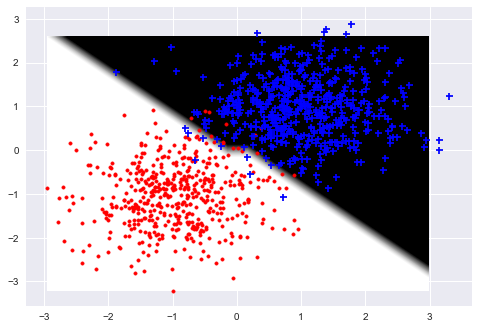

In [1112]:
plot_frontiere(xgentrain, reglog_w, step = 20)
plot_data(xgentrain,ygentrain)

<p>Les valeurs de $f_w$ correspondent au niveau de confiance que l'on accorde à la prédiction: ainsi, si $f_w(x)$ est élevé en valeur absolue, x sera classé avec un haut niveau de confiance, tandis que pour $f_w(x)$ faible on sera moins sûr de notre prédiction. </p>
<p> Cette interprétation est la même pour les deux modèles, cependant f_w ne représentent pas l'estimation de la même grandeur: avec $\eta(x) = P(y=1 | x)$, pour la classification plug-in, $f_w$ estime $\eta(x)$, tandis que pour la régression logistique, $f_w$ estime $log \left( \frac{ \eta(x)}{1-\eta(x)} \right)$. </p>

# Test sur les données réelles

<h3><font color="grey">Classification plug-in</h3>

In [1113]:
class Classifier_plug_in:

    def __init__(self):        
        pass
    
    def predict(self, data):
        X = data
        f = X.dot(self.w[:])
        res = np.where(f > 0, 0, 1)
        return np.array([self.labels_list[res[i]] for i in range (len(data))])
         
        
    
    def fit(self, data, labels):
        labels_set = set(labels)
        self.labels_list = list(labels_set)

        g = lambda w: mse(w,  data, labels)
        dg = lambda w: grad_mse(w, data, labels)

        winit = np.random.rand((data.shape[1]))
        eps = 0.000003 #Semble être le pas minimum pour lequel la descente de gradient ne diverge pas pour toutes les paires.
        max_iter = 200
        
    
        w, fw, dfw = optimize(g, dg, winit, eps, max_iter)
        self.w = w[-1]
                
    def score(self, data, labels):
        return np.where(self.predict(data)==labels, 1, 0).mean()



In [1069]:
F = Classifier_plug_in()

n1, n2 = 6, 9
xtrain, ytrain = get_usps([n1,n2],xuspstrain,yuspstrain)
xtest, ytest = get_usps([n1,n2],xuspstest,yuspstest)

data = np.hstack((np.ones((xtrain.shape[0], 1)), xtrain))
label = np.where(ytrain == n1, 1, -1)

F.fit(data, label)

In [1077]:
data_test = np.hstack((np.ones((xtest.shape[0], 1)), xtest))
label_test = np.where(ytest == n1, 1, -1)

#F.score(data_test, label_test)

Suivant la paire de chiffre, le pas le plus élevé pour lequel la descente de gradient ne divergera pas est différent. Le pas $3.10^{-6}$ semble marché pour toutes les paires étudiées. Cependant le temps de calcul est alors rapidement élevé si on souhaite obtenir des poids performants. En faisant plusieurs test sur la paire $(6, 9)$ ci-dessus, on a obtenu les scores suivants:
$$ \begin{array}{cc}
\text{Nombre d'itération} & \text{Score} \\
200 & \simeq83\% \\
500 & \simeq85\% \\
1000 & \simeq92\% 
\end{array}
$$

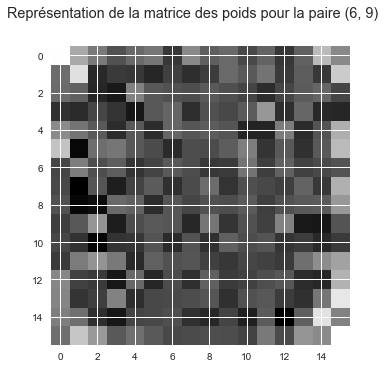

In [964]:
plt.figure()
plt.suptitle('Représentation de la matrice des poids pour la paire (6, 9)')
show_usps(F.w[1:])

À vue d'oeil, la représentation du vecteur de poids en matrice ne semble pas avoir un rapport avec les images étudiées. 

In [1075]:
def fit_xy_2(F, n1, n2):
    '''Fait fitter le Classifier F aux données n1, n2 de USPS'''
    xtrain, ytrain = get_usps([n1,n2],xuspstrain,yuspstrain)
    xtest, ytest = get_usps([n1,n2],xuspstest,yuspstest)

    data = np.hstack((np.ones((xtrain.shape[0], 1)), xtrain))
    label = np.where(ytrain == n1, 1, -1)
    
    F.fit(data, label)
    
    data_test = np.hstack((np.ones((xtest.shape[0], 1)), xtest))
    label_test = np.where(ytest == n1, 1, -1)

    return F.score(data_test, label_test)

Calcul de la paire (0, 1) en cours
Calcul de la paire (0, 2) en cours
Calcul de la paire (0, 3) en cours
Calcul de la paire (0, 4) en cours
Calcul de la paire (1, 2) en cours
Calcul de la paire (1, 3) en cours
Calcul de la paire (1, 4) en cours
Calcul de la paire (2, 3) en cours
Calcul de la paire (2, 4) en cours
Calcul de la paire (3, 4) en cours
Scores de la predictions du classifier plug-in pour toutes les paires de chiffres entre 0 et 4
   200 itérations dans les descentes de gradient


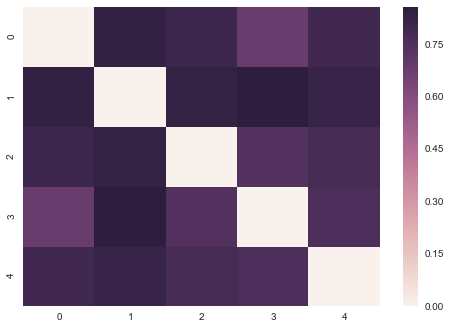

In [1076]:
F = Classifier_plug_in()

matrix = np.zeros((5,5))
for i in range(9):
    for j in range(i+1, 5):
        print('Calcul de la paire ({}, {}) en cours'.format(i,j))
        p = fit_xy_2(F, i, j)
        matrix[i, j] = max(1-p, p)
        matrix[j, i] = matrix[i, j]
print('Scores de la predictions du classifier plug-in pour toutes les paires de chiffres entre 0 et 4\n   200 itérations dans les descentes de gradient')
sns.heatmap(matrix)

Pour éviter un temps de calcul trop long, on ne représente que la matrice des scores de notre prédiction que pour les paires des 5 premiers chiffres. Les résultats opbtenus sont satisfaisant, mais il faudrait faire des descentes de gradients plus longues (de l'ordre de 1000 itérations) pour avoir la plupart des scores au-dessus de 90%. 

<h3><font color="grey">Régression logistique</h3>

In [1114]:
class Classifier_reg_log:

    def __init__(self):        
        pass
    
    def predict(self, data):
        X = data
        sf = sigma(X.dot(self.w[:]))
        res = np.where(sf > 0.5, 0, 1)
        
        return np.array([self.labels_list[res[i]] for i in range (len(data))])
         
        
    
    def fit(self, data, labels):
        labels_set = set(labels)
        self.labels_list = list(labels_set)

        g_rl = lambda w: reglog(w, data, labels)
        dg_rl = lambda w: grad_reglog(w, data, labels)

        winit = np.random.rand((data.shape[1]))
        eps_rl = 0.1
        max_iter_rl = 1000

        w_rl, L_rl, dL_rl = optimize(g_rl, dg_rl, winit, eps_rl, max_iter_rl)        
        self.w = w_rl[-1]
                
    def score(self, data, labels):
        return np.where(self.predict(data)==labels, 1, 0).mean()



In [1115]:
F = Classifier_reg_log()

In [1116]:
n1, n2 = 6, 9
xtrain, ytrain = get_usps([n1,n2],xuspstrain,yuspstrain)
xtest, ytest = get_usps([n1,n2],xuspstest,yuspstest)

data = np.hstack((np.ones((xtrain.shape[0], 1)), xtrain))
label = np.where(ytrain == n1, 1, -1)

data_test = np.hstack((np.ones((xtest.shape[0], 1)), xtest))
label_test = np.where(ytest == n1, 1, -1)

F.fit(data, label)

/Users/Antonin/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in exp
/Users/Antonin/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in exp


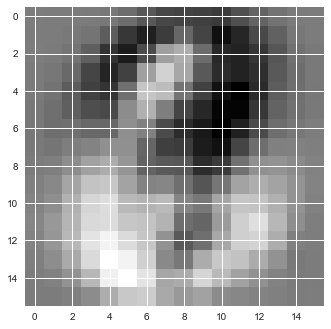

In [1117]:
show_usps(F.w[1:])

Scores de la predictions de la régression logistique pour toutes les paires de chiffres


/Users/Antonin/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in exp
/Users/Antonin/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in exp


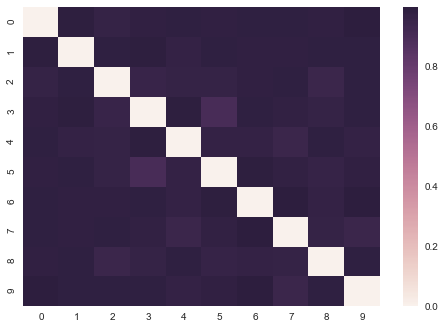

In [734]:
F = Classifier_reg_log()

print('Scores de la predictions de la régression logistique pour toutes les paires de chiffres')
matrix = np.zeros((10,10))
for i in range(9):
    for j in range(i+1, 10):
        p = fit_xy_2(F, i, j)
        matrix[i, j] = max(1-p, p)
        matrix[j, i] = matrix[i, j]
        
sns.heatmap(matrix)

On obtient des résultats très satisfaisant, avec quasiment toutes les paires différencié avec un taux de réussite autour de 95%.